In [2]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
from reader import read_bruker_data
from spectra_manager import BaseSpectraCreator
import spectral_integration
import optimization
import spectra_processing

reload(population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectral_integration)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)

<module 'optimization' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\optimization\\__init__.py'>

### ИЗВЛЕЧЁМ ЭКСПЕРЕМЕНТАЛЬНЫЕ СПЕКТРЫ

In [3]:
import os
import re

import os
import re

def extract_data(folder_path):
    temperatures = []
    file_paths = []
    
    # Convert p notation to decimal for temperatures
    def parse_temp(temp_str):
        if 'p' in temp_str:
            parts = temp_str.split('p')
            return float(parts[0]) + float(parts[1]) / 10**len(parts[1])
        else:
            # Remove 'K' suffix if present
            temp_str = temp_str.rstrip('K')
            return float(temp_str)
    
    # Regex pattern to match your filename format: KY3_{temp}_{attin}.DSC/.DTA
    pattern = r'KY3_([^_]+)_[^_]+\.(DSC)$'
    
    # Walk through the directory structure
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Use regex to extract temperature from filename
            match = re.match(pattern, file)
            if match:
                temp_str = match.group(1)  # Extract the temperature part
                try:
                    temp = parse_temp(temp_str)
                    temperatures.append(temp)
                    file_paths.append(os.path.join(root, file))
                except ValueError as e:
                    print(f"Could not parse temperature from {file}: {e}")
            else:
                print(f"File {file} does not match expected pattern")
    
    return temperatures, file_paths

In [4]:
folder = r"D:\ITC\Эксперементы_на_ЭПР_спектрометре\2025_EPR\Qband_Ksenia_2025_07_11\Qband_Ksenia_2025_07_11\KY3\up"

In [5]:
temperatures, file_paths = extract_data(folder)
results = []
for path in file_paths:
    areas = ((0.0, 1.0), (1.35, 1.5))
    meta, data = read_bruker_data(path)
    x_values = data["x_values"] / 1e4
    data["x_values"] = x_values
    y_values = data["y_values"]
    y_values, _ = spectra_processing.correct_baseline(x_values, y_values, areas, poly_order=1)
    y_values = y_values / max(y_values)
    data["y_values"] = y_values
    results.append((meta, data))

File KY3_107K_30dB.DTA does not match expected pattern
File KY3_10K_35dB.DTA does not match expected pattern
File KY3_113K_30dB.DTA does not match expected pattern
File KY3_123K_30dB.DTA does not match expected pattern
File KY3_136K_30dB.DTA does not match expected pattern
File KY3_152K_30dB.DTA does not match expected pattern
File KY3_175K_30dB.DTA does not match expected pattern
File KY3_20K_30dB.DTA does not match expected pattern
File KY3_210K_30dB.DTA does not match expected pattern
File KY3_36K_30dB.DTA does not match expected pattern
File KY3_4K_35dB.DTA does not match expected pattern
File KY3_52K_30dB.DTA does not match expected pattern
File KY3_67K_30dB.DTA does not match expected pattern
File KY3_6K_35dB.DTA does not match expected pattern
File KY3_80K_30dB.DTA does not match expected pattern
File KY3_90K_30dB.DTA does not match expected pattern
File KY3_96K_30dB.DTA does not match expected pattern


### Зададим спиновую систему

Спиновая система - это три элетронных спина с разными g-тензорами. Один изотропный, и два анизотропных. При температруе порядка 100К в системе наблюдается стркутрынй переход - изменяются обменные энергии и g-tensor branching меди.

При этом ориентация g-тензоров медей известна из струкутруного анализа

In [54]:
fixed_parameters = {}

fixed_parameters["g_rad"] = 2.002

fixed_parameters["J_chain_high_temp"] = 1.4
fixed_parameters["J_branching_high_temp"] = -4.21

fixed_parameters["J_chain_low_temp"] = 1.9
fixed_parameters["J_branching_low_temp"] = -0.23


orien_side_up = torch.tensor(
    [
        [0.8859114, 0.0008034, 0.4638538],
        [0.0005397, -0.9999996, 0.0007013],
        [0.4638541, -0.000371, -0.8859115],]
)

orien_chain_left = torch.tensor(
    [
        [0.744169, 0.4552341, -0.4888501],
        [0.3236334, -0.8859029, -0.3323212],
        [-0.5843577, 0.0890949, -0.8065904]
    ]
)
fixed_parameters["orien_side_up"] = orien_side_up
fixed_parameters["orien_chain_left"] = orien_chain_left


varies_parameters = []
varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_interchain_x", (2.0, 2.14), 2.025)
)
varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_interchain_y", (2.0, 2.14), 2.05)
)
varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_interchain_z", (2.20, 2.30), 2.25)
)


varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_branching_high_temp_x", (2.0, 2.30), 2.07)
)
varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_branching_high_temp_y", (2.0, 2.30), 2.14)
)
varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_branching_high_temp_z", (2.0, 2.30), 2.26)
)


varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_branching_low_temp_x", (2.0, 2.30), 2.19)
)
varies_parameters.append(
    optimization.fitter.ParamSpec("g_cu_branching_low_temp_z", (2.0, 2.30), 2.07)
)

varies_parameters.append(
    optimization.fitter.ParamSpec("delta_g", (-0.01, 0.01), 0.0)
) # Здесь по задаче считается, что <g *g > меняется слабо



varies_parameters.append(
    optimization.fitter.ParamSpec("lorentz_high_temp", (0.00, 0.02), 0.001)
)

varies_parameters.append(
    optimization.fitter.ParamSpec("h_strain_high_temp", (1e8, 1e9), 5e8)
)

varies_parameters.append(
    optimization.fitter.ParamSpec("h_strain_low_temp", (1e8, 1e9), 5e8)
)


varies_parameters.append(
    optimization.fitter.ParamSpec("lorentz_low_temp", (0.00, 0.02), 0.001)
)



param_space = optimization.fitter.ParameterSpace(varies_parameters, fixed_parameters)

### Подгрузим эксперементальные данные - 136K и 90K спектры

In [55]:
###### Эксперементальные данные, которые будут использованы

idx_high = 4
fields_high = results[idx_high][1]["x_values"][300:-300]
y_exp_high = results[idx_high][1]["y_values"][300:-300]
freq_high = results[idx_high][0]["MWFQ"]
temp_high = temperatures[idx_high]


idx_low = -2
fields_low = results[idx_low][1]["x_values"][300:-300]
y_exp_low = results[idx_low][1]["y_values"][300:-300]
freq_low = results[idx_low][0]["MWFQ"]
temp_low = temperatures[idx_low]

Нужно задать метод, который строит спектры. У меня это

from functools import partial

simulate_spectra_partial = partial(
        simulate_spectra,
        mesh=mesh,
        freq_high_temp=freq_high,
        freq_low_temp=freq_low,
        high_temp=temp_high,
        low_temp=temp_low
)

partial я использую, чтобы передать всякие эксперементальный опции. Потом, на следующей итерации подумаю, как это лучше сделать



In [56]:
def build_sample(
    J_chain, J_branching,
    g_rad, g_cu_chain, g_cu_branching,
    orient_side, orient_up, h_strain,
    mesh, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(g_cu_chain_tensor, g1_frame)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, orient_up)
        
        g_rad = torch.full((3,), g_rad)
        g_rad_frame = torch.tensor([0, 0, 0])
        zeem_rad = spin_system.Interaction(g_rad, g_rad_frame)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        e_rad = particles.Electron(spin=0.5)
        
        J_chain = 2 * J_chain # Because 2 S1 S2
        J_chain_hz = (J_chain * 100) * 3 * 1e8
        inter_chain = torch.full((3,), J_chain_hz)
        d_frame = torch.zeros(3)
        ee_int_chain = spin_system.Interaction(inter_chain, d_frame, torch.zeros(3))

        J_branching = 2 * J_branching # Because 2 S1 S2
        J_branching_hz = (J_branching * 100) * 3 * 1e8
        inter_side = torch.full((3,), J_branching_hz)
        d_frame = torch.zeros(3)
        ee_int_side = spin_system.Interaction(inter_side, d_frame, torch.zeros(3))
        
        system = spin_system.SpinSystem(
            electrons=[e_rad, e_chain, e_branching],
            g_tensors=[zeem_rad, zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_side), (0, 2, ee_int_chain)
            ]
        )

        # Homogeneity strain
        hum_str = h_strain * torch.ones(3)
        gauss=0
        return spin_system.MultiOrientedSample(system, hum_str, 0, lorentz, mesh)

def get_powders(params, mesh):
    g_cu_chain = torch.tensor(
        [params["g_cu_interchain_x"],
         params["g_cu_interchain_y"],
         params["g_cu_interchain_z"]]
        )
    
    g_cu_branching_high_temp = torch.tensor(
        [params["g_cu_branching_high_temp_x"],
         params["g_cu_branching_high_temp_y"],
         params["g_cu_branching_high_temp_z"]]
    )
    
    delta_g = params["delta_g"]
    g_cu_branching_low_temp_x = params["g_cu_branching_low_temp_x"]
    g_cu_branching_low_temp_z = params["g_cu_branching_low_temp_z"]
    
    g_cu__intra_sq =  sum(g_cu_branching_high_temp ** 2)
    g_cu_branching_low_temp_y =\
    g_cu__intra_sq - g_cu_branching_low_temp_x ** 2 - g_cu_branching_low_temp_z**2  + delta_g
    g_cu_branching_low_temp_y = g_cu_branching_low_temp_y ** 0.5 
    
    g_cu_branching_low_temp = torch.tensor(
        [params["g_cu_branching_high_temp_x"],
         g_cu_branching_low_temp_y,
         params["g_cu_branching_high_temp_z"]]
    )
    
    powder_high_temp = build_sample(
        J_chain=params["J_chain_high_temp"],
        J_branching=params["J_branching_high_temp"],
        g_rad=params["g_rad"],
        g_cu_chain = g_cu_chain,
        g_cu_branching = g_cu_branching_high_temp,
        orient_side=params["orien_side_up"],
        orient_up=params["orien_chain_left"],
        h_strain=params["h_strain_high_temp"],
        mesh=mesh,
        lorentz=torch.tensor(params["lorentz_high_temp"])
    )
    
    powder_low_temp = build_sample(
        J_chain=params["J_chain_low_temp"],
        J_branching=params["J_branching_low_temp"],
        g_rad=params["g_rad"],
        g_cu_chain = g_cu_chain,
        g_cu_branching = g_cu_branching_low_temp,
        orient_side=params["orien_side_up"],
        orient_up=params["orien_chain_left"],
        h_strain=params["h_strain_low_temp"],
        mesh=mesh,
        lorentz=torch.tensor(params["lorentz_low_temp"])
    )
    
    return powder_high_temp, powder_low_temp
    

class SpectraSimulator:
    def __init__(self, mesh, freq_high_temp, freq_low_temp, high_temp, low_temp, params):
        example_powder = powder_high_temp, powder_low_temp = get_powders(params, mesh)
        self.high_creator = spectra_manager.StationarySpectraCreator(freq_high_temp, powder_high_temp,
                                                                temperature=torch.tensor(high_temp))
        
        self.low_creator = spectra_manager.StationarySpectraCreator(freq_low_temp, powder_low_temp,
                                                                temperature=torch.tensor(low_temp))
        
    def __call__(self, magnetic_fields, params):
        B_high = magnetic_fields[0]
        B_low = magnetic_fields[1]
        powder_high_temp, powder_low_temp = get_powders(params, mesh)
        return [self.high_creator(powder_high_temp, B_high),
                self.low_creator(powder_low_temp, B_low)]
    
    
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2 * np.pi),
                                    initial_grid_frequency=18,
                                    interpolate=True, interpolation_grid_frequency=30)

    
simulate_spectra = SpectraSimulator(mesh, freq_high, freq_low, temp_high, temp_low, param_space)

In [57]:
len(optimization.SpectrumFitter.__available_optimizer__["nevergrad"] + optimization.SpectrumFitter.__available_optimizer__["optuna"])

548

### Создадим объект fitter и зафитируем спектры

In [58]:
from functools import partial

fitter = optimization.SpectrumFitter(
    x_exp=[fields_high, fields_low],
    y_exp=[y_exp_high, y_exp_low],
    param_space=param_space,
    spectra_simulator=simulate_spectra
)

In [ ]:
import optuna
result = fitter.fit(backend="optuna", n_trials=3000)

In [ ]:
fitter.__available_optimizer__

In [ ]:
result

In [60]:
param_names = ['g_cu_interchain_x',
                 'g_cu_interchain_y',
                 'g_cu_interchain_z',
                 'g_cu_branching_high_temp_x',
                 'g_cu_branching_high_temp_y',
                 'g_cu_branching_high_temp_z', 
                 'g_cu_branching_low_temp_x',
                 'g_cu_branching_low_temp_z'
                ]

In [61]:
best_params = result.best_params
new_param_space = param_space.copy()
new_param_space.set_default(best_params)
new_param_space.reduce_bounds(alpha=0.01)

In [62]:
import nevergrad
fitter.param_space = new_param_space
new_result = fitter.fit(backend="ng", budget=100, optimizer_name="Cobyla")

 10%|████████                                                                         | 10/100 [00:02<00:21,  4.20it/s]

Step 10: Loss = 0.043484


 20%|████████████████▏                                                                | 20/100 [00:04<00:18,  4.23it/s]

Step 20: Loss = 0.300587


 30%|████████████████████████▎                                                        | 30/100 [00:06<00:16,  4.23it/s]

Step 30: Loss = 0.305138


 40%|████████████████████████████████▍                                                | 40/100 [00:09<00:14,  4.14it/s]

Step 40: Loss = 0.054321


 50%|████████████████████████████████████████▌                                        | 50/100 [00:11<00:12,  4.02it/s]

Step 50: Loss = 0.053690


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:14<00:09,  4.14it/s]

Step 60: Loss = 0.294654


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:16<00:07,  4.15it/s]

Step 70: Loss = 0.054913


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:19<00:04,  4.13it/s]

Step 80: Loss = 0.054744


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:21<00:02,  4.01it/s]

Step 90: Loss = 0.054028


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]

Step 100: Loss = 0.363238


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


### Сравним с эксперементальынми спектарми

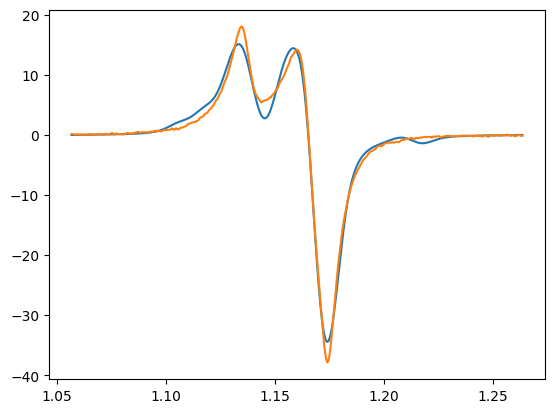

In [63]:
plt.plot(fitter.x_exp[0].numpy(), new_result.best_spectrum[0].numpy())
plt.plot(fitter.x_exp[0].numpy(), fitter.y_exp[0].numpy())
plt.savefig("spec_1.eps")

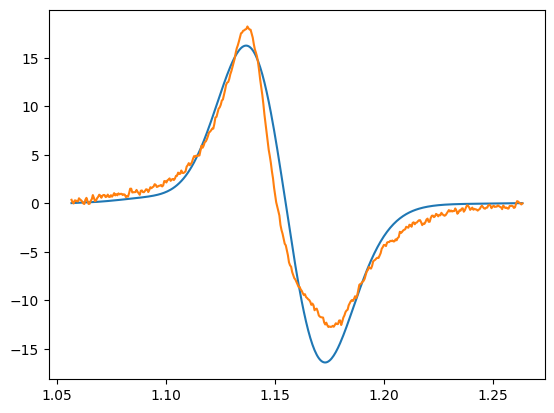

In [64]:
plt.plot(fitter.x_exp[1].numpy(), new_result.best_spectrum[1].numpy())
plt.plot(fitter.x_exp[1].numpy(), fitter.y_exp[1].numpy())
plt.savefig("spec_2.eps")

### как-то в попадаетresult.best_params. В целом, в финильной статье выглядит немного лучше

Теперь попробуем поискать другие минимумы, с другими g-тензорами. Оставим только их имена

In [65]:
space_searcher = optimization.fitter.SpaceSearcher(
    loss_rel_tol=0.5
)
param_names = [
    "g_cu_interchain_x",
    "g_cu_interchain_y",
    "g_cu_interchain_z",
    "g_cu_branching_high_temp_x",
    "g_cu_branching_high_temp_y",
    "g_cu_branching_high_temp_z", 
    "g_cu_branching_low_temp_x",
    "g_cu_branching_low_temp_z"
]
searcher_result = space_searcher(result, param_names)

In [87]:
optimization.print_trial_results(searcher_result)

TRIAL #1990
index: 0
----------------------------------------
Loss:     0.068565
Distance: 4.506632

PARAMETERS:
----------------------------------------
  g_cu_interchain_x          =        2.072407 (Δ -0.016635)
  g_cu_interchain_y          =        2.139978 (Δ +0.082782)
  g_cu_interchain_z          =        2.202609 (Δ -0.046734)
  g_cu_branching_high_temp_x =        2.259578 (Δ +0.085763)
  g_cu_branching_high_temp_y =        2.101595 (Δ -0.045727)
  g_cu_branching_high_temp_z =        2.105411 (Δ -0.060676)
  g_cu_branching_low_temp_x  =        2.186925 (Δ +0.184849)
  g_cu_branching_low_temp_z  =        2.088985 (Δ -0.168940)
  delta_g                    =        0.008788 (Δ +0.002295)
  lorentz_high_temp          =        0.005129 (Δ -0.001641)
  h_strain_high_temp         =      3.4181e+08 (Δ +8.3465e+07)
  h_strain_low_temp          =      9.6648e+08 (Δ -3.1599e+07)
  lorentz_low_temp           =        0.009364 (Δ +0.006979)


TRIAL #2066
index: 1
--------------------------

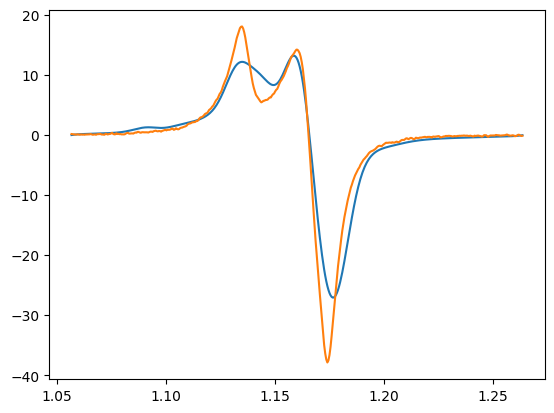

In [67]:
spec_high, spec_low = fitter.simulate_spectra_from_trial_params(searcher_result[0]["params"])

plt.plot(fitter.x_exp[0].numpy(), spec_high.numpy())
plt.plot(fitter.x_exp[0].numpy(), fitter.y_exp[0].numpy())

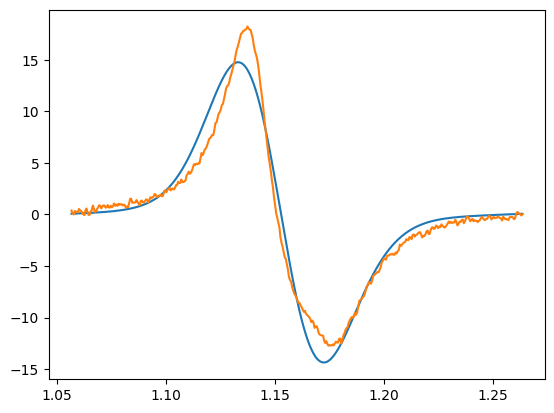

In [68]:
spec_high, spec_low = fitter.simulate_spectra_from_trial_params(searcher_result[0]["params"])

plt.plot(fitter.x_exp[1].numpy(), spec_low.numpy())
plt.plot(fitter.x_exp[1].numpy(), fitter.y_exp[1].numpy())

In [82]:
best_params = result.best_params
new_param_space = param_space.copy()
new_param_space.set_default(searcher_result[1]["params"])
new_param_space.reduce_bounds(None, alpha=0.01)

fitter.param_space = new_param_space
new_result = fitter.fit(backend="ng", budget=200, optimizer_name="Cobyla")

  5%|████                                                                             | 10/200 [00:02<00:44,  4.26it/s]

Step 10: Loss = 0.054161


 10%|████████                                                                         | 20/200 [00:04<00:42,  4.20it/s]

Step 20: Loss = 0.052778


 15%|████████████▏                                                                    | 30/200 [00:06<00:40,  4.17it/s]

Step 30: Loss = 0.335476


 20%|████████████████▏                                                                | 40/200 [00:09<00:38,  4.18it/s]

Step 40: Loss = 0.042008


 25%|████████████████████▎                                                            | 50/200 [00:11<00:35,  4.22it/s]

Step 50: Loss = 0.333586


 30%|████████████████████████▎                                                        | 60/200 [00:14<00:32,  4.28it/s]

Step 60: Loss = 0.333649


 35%|████████████████████████████▎                                                    | 70/200 [00:16<00:32,  4.03it/s]

Step 70: Loss = 0.334307


 40%|████████████████████████████████▍                                                | 80/200 [00:19<00:29,  4.11it/s]

Step 80: Loss = 0.052516


 45%|████████████████████████████████████▍                                            | 90/200 [00:21<00:27,  4.02it/s]

Step 90: Loss = 0.329367


 50%|████████████████████████████████████████                                        | 100/200 [00:24<00:23,  4.20it/s]

Step 100: Loss = 0.332119


 55%|████████████████████████████████████████████                                    | 110/200 [00:26<00:21,  4.12it/s]

Step 110: Loss = 0.334404


 60%|████████████████████████████████████████████████                                | 120/200 [00:28<00:18,  4.25it/s]

Step 120: Loss = 0.052590


 65%|████████████████████████████████████████████████████                            | 130/200 [00:31<00:16,  4.14it/s]

Step 130: Loss = 0.041656


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:33<00:16,  3.75it/s]

Step 140: Loss = 0.041656


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:36<00:12,  4.07it/s]

Step 150: Loss = 0.041655


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:38<00:10,  3.83it/s]

Step 160: Loss = 0.041655


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [00:41<00:08,  3.73it/s]

Step 170: Loss = 0.041655


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [00:44<00:04,  4.08it/s]

Step 180: Loss = 0.041655


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [00:46<00:02,  3.98it/s]

Step 190: Loss = 0.041655


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.10it/s]

Step 200: Loss = 0.041655


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.03it/s]


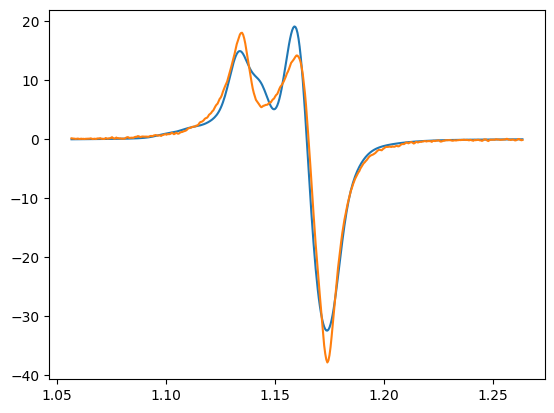

In [83]:
plt.plot(fitter.x_exp[0].numpy(), new_result.best_spectrum[0].numpy())
plt.plot(fitter.x_exp[0].numpy(), fitter.y_exp[0].numpy())
plt.savefig("new_spec_1.eps")

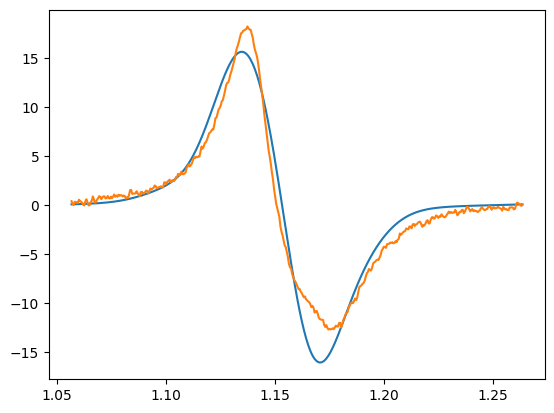

In [84]:
plt.plot(fitter.x_exp[1].numpy(), new_result.best_spectrum[1].numpy())
plt.plot(fitter.x_exp[1].numpy(), fitter.y_exp[1].numpy())
plt.savefig("new_spec_2.eps")

In [ ]:
new_result

In [122]:
min_idx = index[0]
max_idx = index[-1]

data[(min_idx-1):(max_idx)].shape

torch.Size([3, 2, 4])